In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

import sys
sys.path.append("../")

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
from particles.core import SMC
from particles import smc_samplers as ssp
import seaborn
from tqdm import tqdm
import pickle
import os

from Utils import *

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

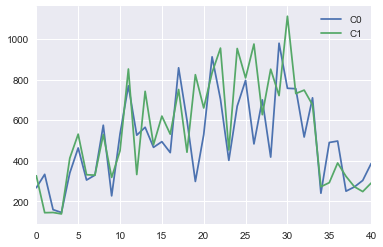

In [2]:
data[['C0','C1']].plot()

In [3]:
print(mean_N0, std_N0)

296.5 29.5


In [4]:
n_particles = 4000
n_iter = 20000

# Definition of a Logistic Diffusion State-Space Models

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$

In our experiments we are just going to discretize this equation as follow:

$$ log(y_{t+1}) = log(y_t) + (r+\frac{\sigma^2}{2}-b\times y_t)\Delta_t + \sigma N(0, \Delta_t) $$

If we implement the model considering $z_t = log(y_t)$, we simply get:

$$ z_{t+1} \sim N(z_t + (r+\frac{\sigma^2}{2}-b\times exp(z_t))\Delta_t, \Delta_t )$$ 

This is the transition distribution, for the emission distribution we simply use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

We add a first simple model for the case where $\tau$ is also set to 0 (so the emission distribution because a Poisson of rate $y_t$).

## Tests with all models

### A Random Walk Model with Poisson emission distribution

In [6]:
prior_RWp = {'sigma': dists.Uniform(a=0.,b=10.)}
load_model = False

if load_model:
    pmmh_RWp = pickle.load(open( os.path.join(path,"RWp_model.pkl"), "rb" ))
else:
    p_RWp = dists.StructDist(prior_RWp)
    pmmh_RWp = mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RWp, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RWp.run()

In [168]:
print_metrics(pmmh_RWp)
plot_theta(prior_RWp, pmmh_RWp)

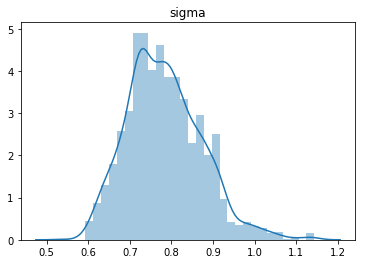

In [56]:
distplot(prior_RWp, pmmh_RWp, 250)

In [148]:
simulRWp = get_trajectories(N=100, start=500, model='poisson', pmmh=pmmh_RWp, n_particles=10000)

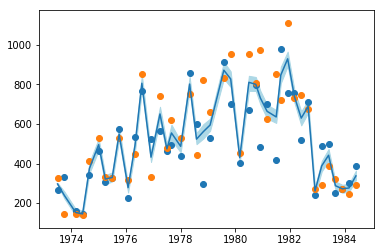

In [149]:
plot_posterior_trajectories(simulRWp)

## Random Walk Model (M3)

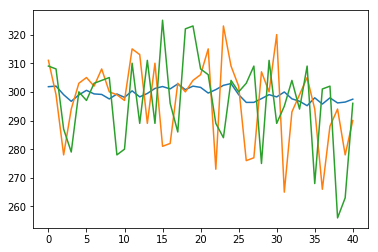

In [10]:
RW = RandomWalk2D(sigma=0.01,tau=0.0001)
simulate_plot(RW)

In [21]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
load_model = True

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model.pkl"), "rb" ))
else:
    p_RW = dists.StructDist(prior_RW)
    pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_RW.run()
    # pickle.dump(pmmh_RW, open( os.path.join(path,"RW_model.pkl"), "wb" ) )

mean square jump distance: 133.93014469998243
posterior loglikelihood: [-536.81758867 -536.81758867 -536.81758867 -536.81758867 -536.81758867]
Acceptance rate: 0.35241762088104406
Last terms of theta chain: [(0.53149593, 0.05470937) (0.53149593, 0.05470937)
 (0.53149593, 0.05470937)]


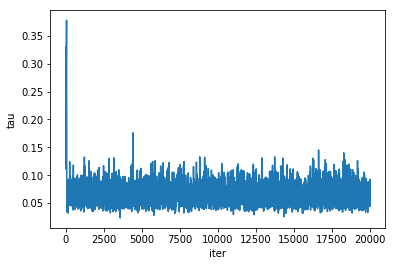

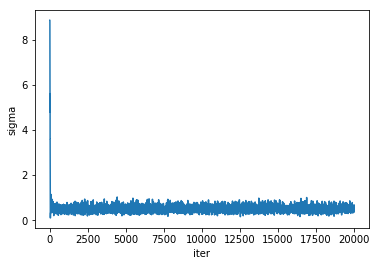

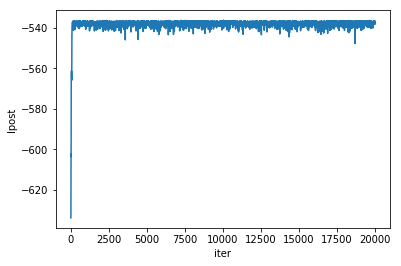

In [169]:
print_metrics(pmmh_RW)
plot_theta(prior_RW,pmmh_RW)

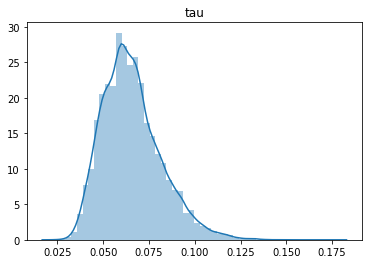

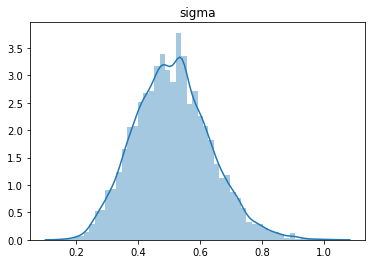

In [23]:
distplot(prior_RW, pmmh_RW, 500)

In [16]:
simulRW = get_trajectories(N=100, start=500, model='RW', pmmh=pmmh_RW, n_particles=10000)

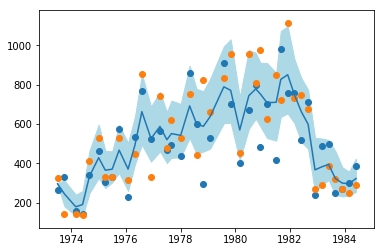

In [17]:
plot_posterior_trajectories(simulRW)

## Logistic Diffusion process with drift (M2)

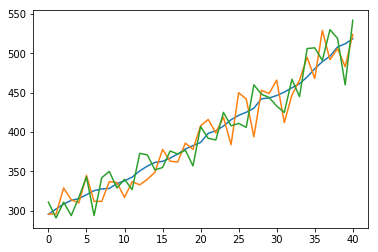

In [27]:
Ldrift = LDPDrift(sigma=0.01,tau=0.0001, r=0.05)
simulate_plot(Ldrift)

In [29]:
prior_Ldrift = {'tau': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}

load_model = True

if load_model:
    pmmh_Ldrift = pickle.load(open( os.path.join(path,"Ldrift_model.pkl"), "rb" ))
else:
    p_Ldrift = dists.StructDist(prior_Ldrift)
    pmmh_Ldrift= mcmc.PMMH(ssm_cls=LDPDrift, prior=p_Ldrift, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_Ldrift.run()
    # pickle.dump(pmmh_Ldrift, open( os.path.join(path,"Ldrift_model.pkl"), "wb" ) )

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [33:46<00:00,  9.87it/s]


mean square jump distance: 242.54698749308335
posterior loglikelihood: [-539.94452765 -539.94452765 -539.94452765 -539.94452765 -539.94452765]
Acceptance rate: 0.30756537826891345
Last terms of theta chain: [(0.0299779, 0.52289305, 0.06859551) (0.0299779, 0.52289305, 0.06859551)
 (0.0299779, 0.52289305, 0.06859551)]


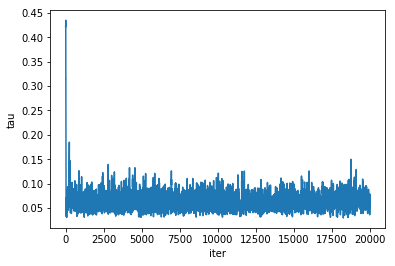

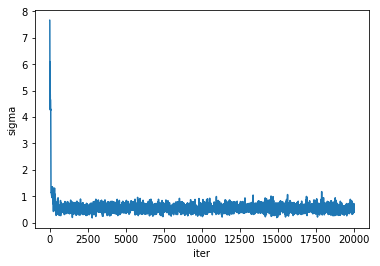

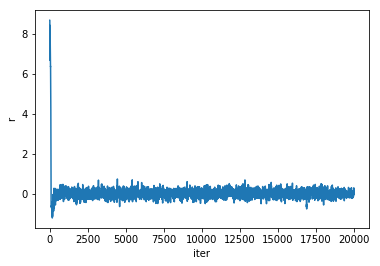

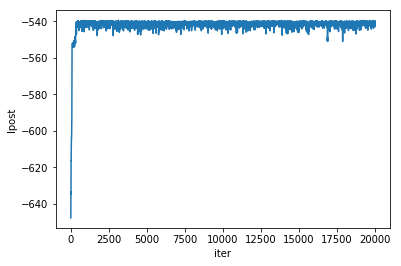

In [170]:
print_metrics(pmmh_Ldrift)
plot_theta(prior_Ldrift,pmmh_Ldrift)

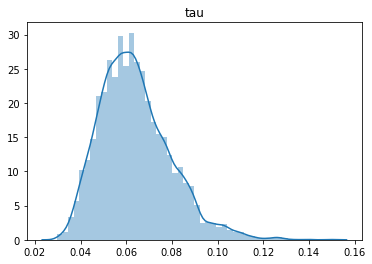

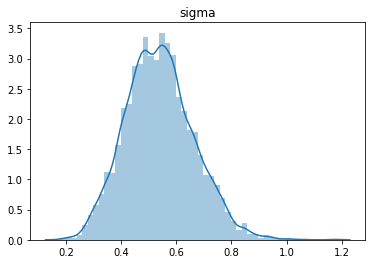

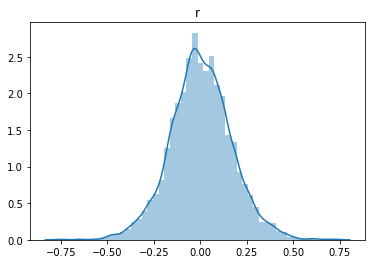

In [31]:
distplot(prior_Ldrift,pmmh_Ldrift,1000)

In [32]:
simulLDrift = get_trajectories(N=100, start=500, model='LDrift', pmmh=pmmh_Ldrift, n_particles=10000)

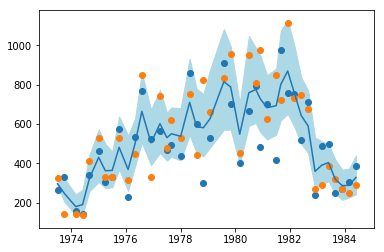

In [33]:
plot_posterior_trajectories(simulLDrift)

## Logistic Diffusion process with drift and restoring force: No Euler discretization

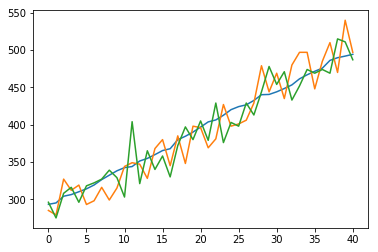

In [23]:
LD = LogisticDiffusion2D(sigma=0.01,k=0.0001, r=0.005, b=1e-6)
simulate_plot(Ldrift)

In [47]:
prior_LD = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = True

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LD_model.pkl"), "rb" ))
else:
    p_LD = dists.StructDist(prior_LD)
    pmmh_LD= mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=p_LD, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
    pmmh_LD.run()
    # pickle.dump(pmmh_LD, open( os.path.join(path,"LD_model.pkl"), "wb" ) )

mean square jump distance: 238.1571313016029
posterior loglikelihood: [-541.20994155]
Acceptance rate: 0.24746237311865593
Last terms of theta chain: [(0.00049763, 0.08628207, -0.10844376, 0.38487874)
 (0.00049763, 0.08628207, -0.10844376, 0.38487874)
 (0.00049763, 0.08628207, -0.10844376, 0.38487874)]


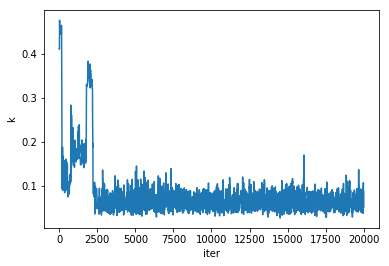

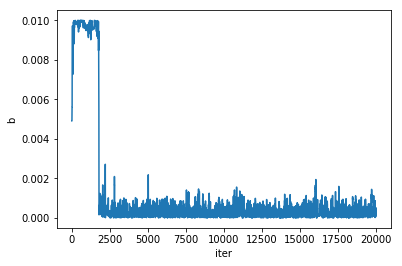

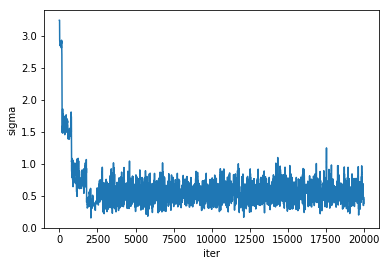

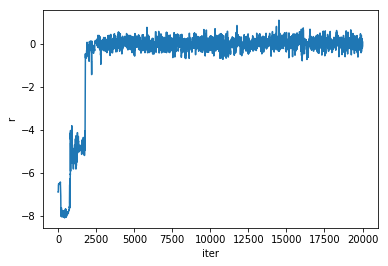

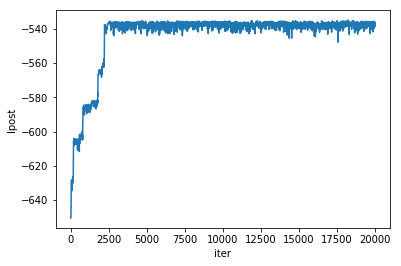

In [48]:
print_metrics(pmmh_LD)
plot_theta(prior_LD,pmmh_LD)

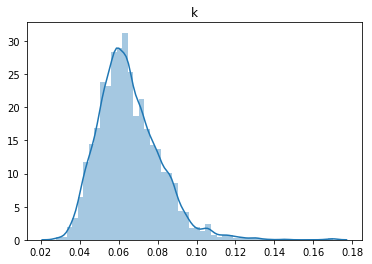

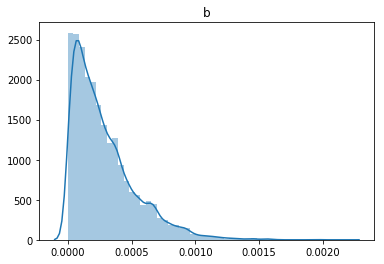

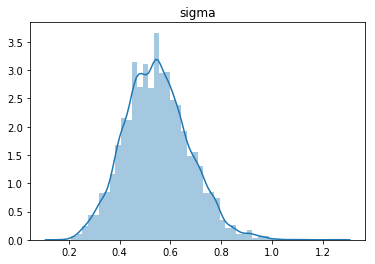

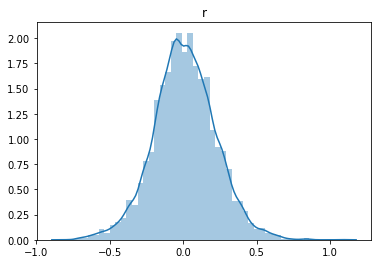

In [49]:
distplot(prior_LD,pmmh_LD, 5000)

In [176]:
simulLD = get_trajectories(N=100, start=2500, model='LD', pmmh=pmmh_LD, n_particles=10000)

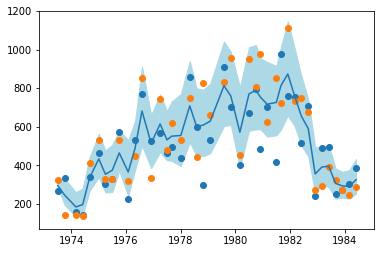

In [177]:
plot_posterior_trajectories(simulLD)

## Logistic Diffusion process with Euler Discretization (M1)

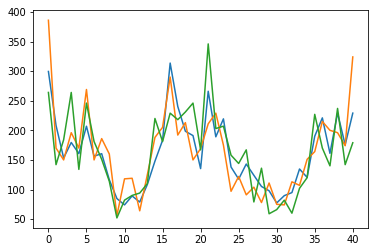

In [188]:
my_ssm = LDEuler(r=0.005, b=0.003, sigma=0.6, tau=0.06)
simulate_plot(my_ssm)

In [189]:
prior_LDEuler = {'tau': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=10.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-10., b=10.)}
load_model = False

if load_model:
    pmmh_LD = pickle.load(open( os.path.join(path,"LDEuler_model.pkl"), "rb" ))
else:
    p_LDEuler = dists.StructDist(prior_LDEuler)
    pmmh_LDEuler= mcmc.PMMH(ssm_cls=LDEuler, prior=p_LDEuler, data=y, Nx=n_particles, niter=1000, adaptive=True)
    pmmh_LDEuler.run()
    pickle.dump(pmmh_LDEuler, open( os.path.join(path,"LDEuler_model.pkl"), "wb" ) )

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  5.42it/s]


mean square jump distance: 0.00019822071832097785
posterior loglikelihood: [-10431.3574778 -10431.3574778 -10431.3574778 -10431.3574778
 -10431.3574778]
Acceptance rate: 0.007007007007007007
Last terms of theta chain: [(6.54095742, 7.25178484, 7.94124875, 0.92021545)
 (6.54095742, 7.25178484, 7.94124875, 0.92021545)
 (6.54095742, 7.25178484, 7.94124875, 0.92021545)]


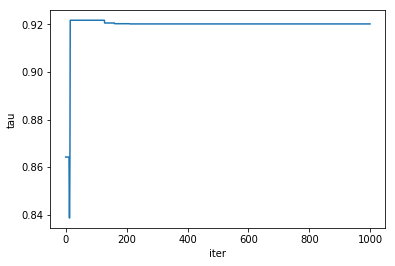

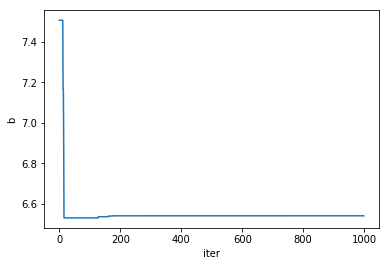

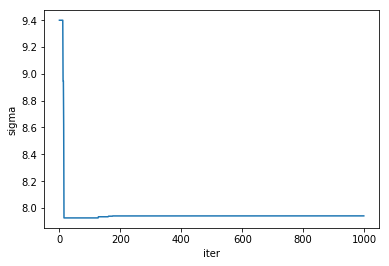

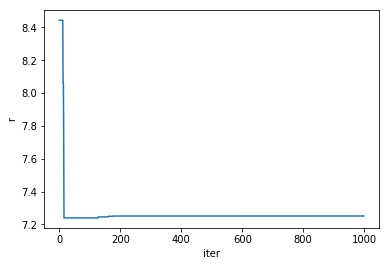

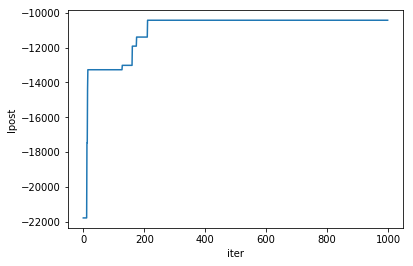

In [190]:
print_metrics(pmmh_LDEuler)
plot_theta(prior_LDEuler,pmmh_LDEuler)

In [191]:
simulLDEuler = get_trajectories(N=100, start=500, model='LDEuler', pmmh=pmmh_LDEuler, n_particles=10000)

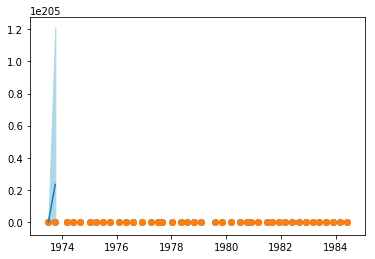

In [192]:
plot_posterior_trajectories(simulLDEuler)

# Test with new Adaptation method

## Random Walk model

In [5]:
prior_RW = {'tau': dists.Uniform(a=0.,b=1.),'sigma': dists.Uniform(a=0.,b=10.)}
load_model = False

if load_model:
    pmmh_RW = pickle.load(open( os.path.join(path,"RW_model_Adapt.pkl"), "rb" ))
else:
    p_RW = dists.StructDist(prior_RW)
    new_pmmh_RW= AdaptivePMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=5000, adaptive=True,
                          m1=400, m2=1600, update_interv=100, w01=0.4, w02=0.5, w1=0.8, k0=5., k1=5.)
    new_pmmh_RW.run()
    # pickle.dump(pmmh_RW, open( os.path.join(path,"RW_model_Adapt.pkl"), "wb" ) )

mean square jump distance: 0.0
posterior loglikelihood: [-538.70236294 -538.70236294 -538.70236294 -538.70236294 -538.70236294]
Acceptance rate: 0.004400880176035207
Last terms of theta chain: [(0.56390832, 0.03869391) (0.56390832, 0.03869391)
 (0.56390832, 0.03869391)]


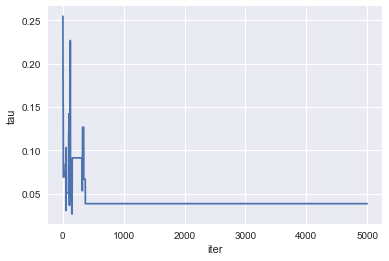

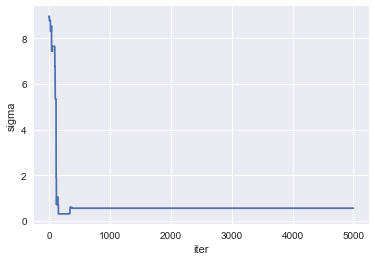

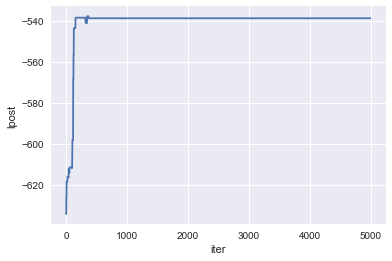

In [6]:
print_metrics(new_pmmh_RW)
plot_theta(prior_RW,new_pmmh_RW)

# Further work

## Guided PF

The main task when working with guided PF is the choice of the guide distribution. A definition of an optimal guide is provided in the lecture, but its exact computation is not tractable in our case. We first look if a Gaussian distribution could be a good approximation for the negative binomial distribution with a simple example similar to our problem.

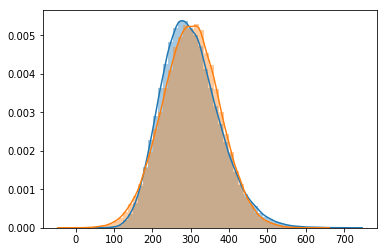

In [46]:
L=[]
K=[]
for i in range(100000):
    L.append(dists.NegativeBinomial(n=1/0.06, p=1/(1+0.06*300)).rvs()[0])
    K.append(dists.Normal(loc=300., scale=np.sqrt(300*(1+0.06*300))).rvs())
seaborn.distplot(L)
seaborn.distplot(K)